In [0]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline

from keras.layers import Activation, ReLU

from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator

# from numpy.random import seed
# seed(2)
# from tensorflow import set_random_seed
# set_random_seed(1)


In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


(60000, 28, 28)


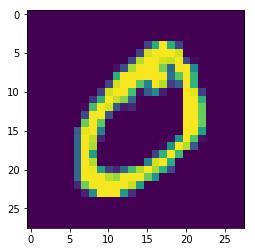

In [30]:
print (X_train.shape)
plt.imshow(X_train[1].reshape(28,28))

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
y_train[:10]
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [34]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

## Normalized the image using ImageDataGenerator

- Here i have initialized the datagen object and fit the object on train data 

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)

datagen.fit(X_train)

In [0]:

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_227', model = None):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))


# L2 regularization

- L2 loss function where lambda is 0.001 and used __m__ as the batch size
![L2 regularization](images/L2.png)

In [0]:
import keras.backend as K
def loss_with_reg(model, batch_size, _lambda = 0.001):
  reg_loss_sqr = 0
  for layer in model.layers:
    if len(layer.get_weights()) > 0:
      reg_loss_sqr += np.sum(layer.get_weights()[0]**2)
  reg_loss_sqr = reg_loss_sqr * (_lambda/2*batch_size)
    
  def temp(y_true,y_pred):
    return K.categorical_crossentropy(y_true, y_pred)+reg_loss_sqr
  return temp

# Used ReLU after batch normalization


In [147]:


from keras.layers import Activation
model_BN_Dout = Sequential()
 
model_BN_Dout.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1))) #26
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))

model_BN_Dout.add(Convolution2D(20, 3, 3, activation=None)) #24
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(MaxPooling2D(pool_size=(2, 2)))#11
model_BN_Dout.add(Convolution2D(10, 1, 1, activation=None)) #22
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())


model_BN_Dout.add(Convolution2D(16, 3, 3, activation=None))#9
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation=None))#7
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation=None))#5
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(16, 3, 3, activation=None))#3
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(ReLU())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Convolution2D(10, 4, 4))
model_BN_Dout.add(BatchNormalization())
model_BN_Dout.add(Dropout(0.05))


model_BN_Dout.add(Flatten())
model_BN_Dout.add(Activation('softmax'))


model_BN_Dout.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (3, 3), activation=None)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation=None)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call t

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_33 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_29 (Dropout)         (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 20)        2900      
_________________________________________________________________
batch_normalization_34 (Batc (None, 24, 24, 20)        80        
_________________________________________________________________
re_lu_25 (ReLU)              (None, 24, 24, 20)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 24, 24, 20)        0         
__________

## Achieved 99.59% with 14,736 parameters after using L2 normalization

- once it reached 99.62% but however i am unable to reproduce the same result. Might have converged to a better optimum

In [51]:
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

batch_size=128

earlyStopping = EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model_BN_Dout.compile(loss=loss_with_reg(model_BN_Dout,batch_size), optimizer=Adam(lr = 0.003), metrics=['accuracy'])

model_BN_Dout.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size,\
                            validation_data = datagen.flow(X_test, Y_test, batch_size=len(X_train)), validation_steps = 1 ,epochs=40, \
                            verbose = 1, callbacks=[earlyStopping, mcp_save, LearningRateScheduler(scheduler, verbose=1)], workers=20, use_multiprocessing=False)
#model_BN_Dout.fit(X_train, Y_train, batch_size=batch_size, epochs=40, verbose=1, validation_data=(X_test, Y_test),callbacks=[earlyStopping, mcp_save, LearningRateScheduler(scheduler, verbose=1)])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
469/468 [==============================] - 21s 46ms/step - loss: 499.8155 - acc: 0.9750 - val_loss: 499.7693 - val_acc: 0.9936
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
469/468 [==============================] - 12s 27ms/step - loss: 499.8025 - acc: 0.9786 - val_loss: 499.7686 - val_acc: 0.9934
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
469/468 [==============================] - 12s 26ms/step - loss: 499.7965 - acc: 0.9805 - val_loss: 499.7656 - val_acc: 0.9934
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
469/468 [==============================] - 12s 27ms/step - loss: 499.7946 - acc: 0.9804 - val_loss: 499.7651 - val_acc: 0.9946
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0043936731.
469/468 [==============================] - 13s 27ms/step - loss: 499.78

In [107]:
model_BN_Dout.load_weights(filepath = './mdl_wts.hdf5')
score = model_BN_Dout.evaluate_generator(datagen.flow(X_test, Y_test, batch_size=len(X_test)), steps = 1)
print(score)

[499.7626037597656, 0.9958999752998352]


## Model convergence for Loss and Accuracy

- Difference train and test, loss and accuracy seems to be big. It looks big in image because model started converging from 99.36 in test data and 97.40 in train data

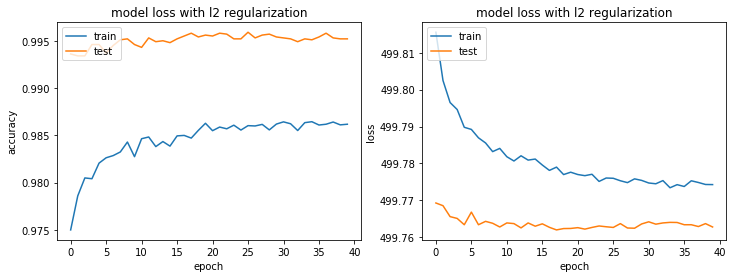

In [60]:
w=10
h=10
fig=plt.figure(figsize=(12, 4))
columns = 2
rows = 1

plt.subplot(121)
plt.plot(model_BN_Dout.history.history['acc'])
plt.plot(model_BN_Dout.history.history['val_acc'])
plt.title('model loss with l2 regularization')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(model_BN_Dout.history.history['loss'])
plt.plot(model_BN_Dout.history.history['val_loss'])
plt.title('model loss with l2 regularization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()


## Calculating predicted labels on test data

In [0]:
y_pred = np.argmax(model_BN_Dout.predict_generator(datagen.flow(X_test, batch_size=len(X_test), shuffle = False),steps = 1), axis = 1)
y_true = y_test

## Calculating miscalssified data

In [0]:
misclassified_index = [ind for ind,(i,j) in enumerate(zip(y_pred,y_true)) if i != j]

## A total of 41 mis classified images

In [151]:
len(misclassified_index)

41

## Making a collage of 25 mis classified images

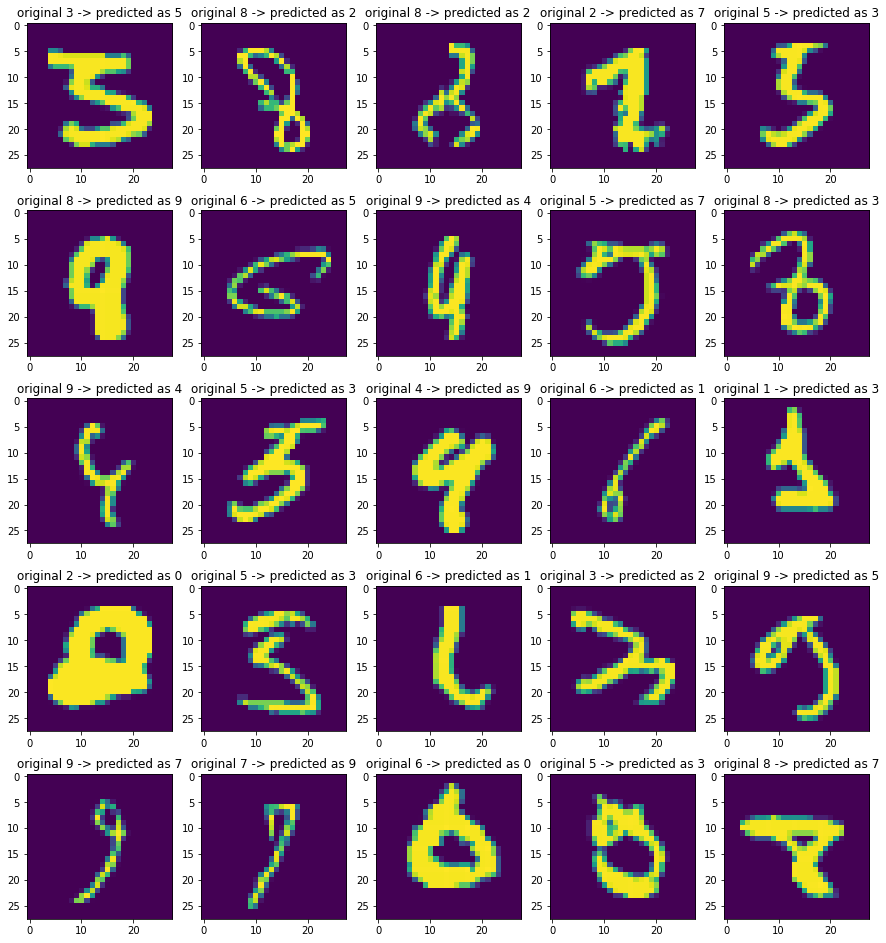

In [130]:
w=10
h=10
fig=plt.figure(figsize=(9, 9))
columns = 5
rows = 5

for i,ind in enumerate(misclassified_index[:25]):
  fig.add_subplot(5,5, i+1)
  plt.imshow(X_test[ind].reshape(28,28))  
  plt.title('original {} -> predicted as {}'.format(y_true[ind],y_pred[ind]))

plt.subplots_adjust(left=2, bottom=2, right=3.3, top=3.4, wspace=None, hspace=None)

plt.show()

# heat map on predicted and original labels
- Visualisation of how many labels are mis-classified and with which class they are confused most with

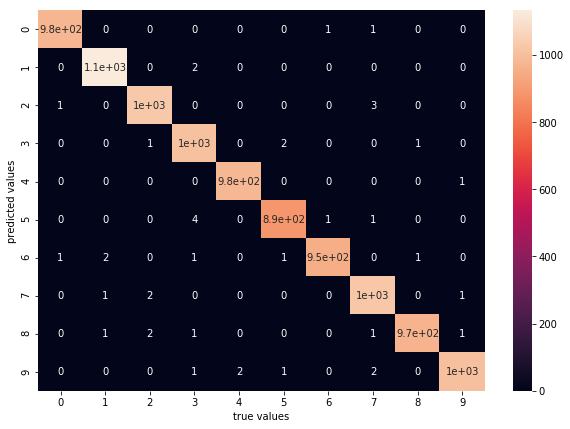

In [142]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

c_matrix = confusion_matrix(y_true,y_pred)

df_cm = pd.DataFrame(c_matrix, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
ax =  sns.heatmap(df_cm, annot=True)
ax.set(xlabel = "true values", ylabel = "predicted values")
plt.show()

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model_BN_Dout.layers])

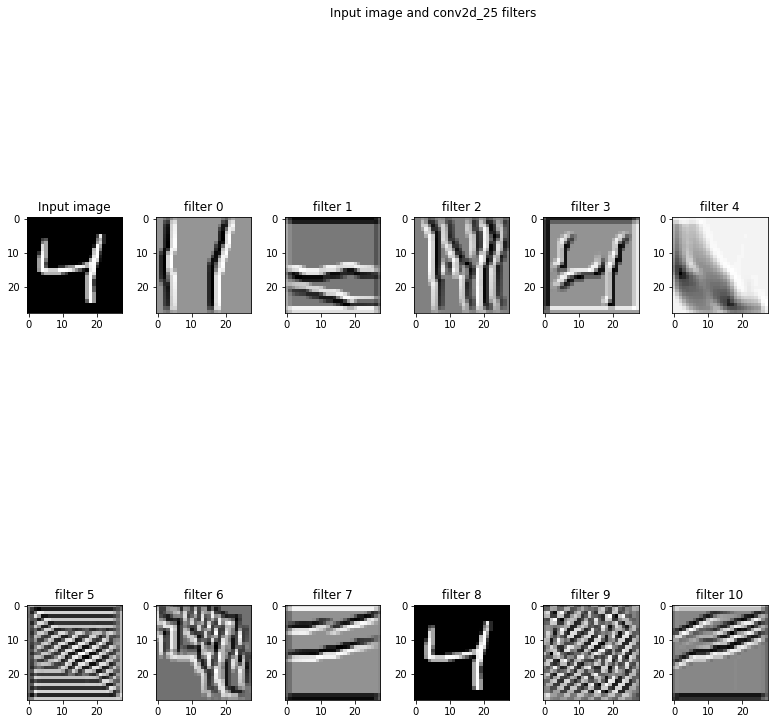

In [144]:
vis_img_in_filter(layer_name = model_BN_Dout.layers[0].name, model = model_BN_Dout)

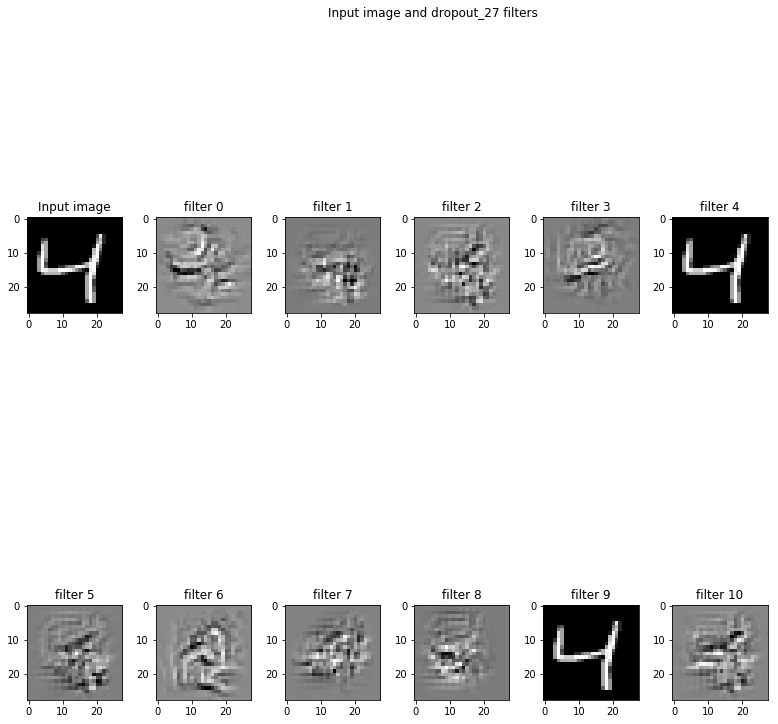

In [145]:
vis_img_in_filter(layer_name = model_BN_Dout.layers[26].name, model = model_BN_Dout)